## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [15]:
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.regularizers import l1, l2, l1_l2
"""
建立神經網路，並加入 dropout layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2,batch_norm=True,l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),kernel_regularizer=l2(l2_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
            if batch_norm ==True:
                x=BatchNormalization()(x)
            else:
                print("No Batch Normalization")
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),kernel_regularizer=l2(l2_ratio))(x)
            x = Dropout(drp_ratio)(x)
            if batch_norm ==True:
                x=BatchNormalization()(x)
            else:
                print("No Batch Normalization")
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [16]:
LEARNING_RATE = 1e-3
EPOCHS = 50
Batch_Norm=[True,False]
BATCH_SIZE = [128,256]
l2_rate=[0,1e-2]
MOMENTUM = 0.95
Dropout_EXP = [0,25e-2]

In [17]:
results = {}
for norm in Batch_Norm:
    keras.backend.clear_session()
    print("Experiment with Batch_Normalization: %s" % (str(norm)))
    for drop in Dropout_EXP:
        print("Experiment with Dropout: %s" % (str(drop)))
        for l2_r in l2_rate:
            print("Experiment with L2_rate: %s" % (str(l2_r)))
            for batch in BATCH_SIZE:
                model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=drop,batch_norm=norm,l2_ratio=l2_r)
                model.summary()
                optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
                model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

                model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=batch, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
                train_loss = model.history.history["loss"]
                valid_loss = model.history.history["val_loss"]
                train_acc = model.history.history["accuracy"]
                valid_acc = model.history.history["val_accuracy"]
                exp_name_tag = "exp-Batch_Norm-%s,Dropout-%s, L2rate-%s,batchsize-%s" % (str(norm),str(drop),str(l2_r),str(batch))
                results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc} 

Experiment with Batch_Normalization: True
Experiment with Dropout: 0
Experiment with L2_rate: 0
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_____________________________

Epoch 43/50
50000/50000 [==============================] - 6s 124us/step - loss: 0.4339 - accuracy: 0.8438 - val_loss: 2.0958 - val_accuracy: 0.5082
Epoch 44/50
50000/50000 [==============================] - 6s 125us/step - loss: 0.4217 - accuracy: 0.8491 - val_loss: 2.3170 - val_accuracy: 0.4892
Epoch 45/50
50000/50000 [==============================] - 6s 124us/step - loss: 0.4139 - accuracy: 0.8495 - val_loss: 2.3221 - val_accuracy: 0.4753
Epoch 46/50
50000/50000 [==============================] - 6s 126us/step - loss: 0.4088 - accuracy: 0.8514 - val_loss: 2.2930 - val_accuracy: 0.4892
Epoch 47/50
50000/50000 [==============================] - 6s 128us/step - loss: 0.4049 - accuracy: 0.8536 - val_loss: 2.3209 - val_accuracy: 0.4830
Epoch 48/50
50000/50000 [==============================] - 7s 136us/step - loss: 0.3960 - accuracy: 0.8563 - val_loss: 2.3207 - val_accuracy: 0.4799
Epoch 49/50
50000/50000 [==============================] - 6s 127us/step - loss: 0.3844 - accuracy: 0.8610

Epoch 36/50
50000/50000 [==============================] - 4s 87us/step - loss: 0.3889 - accuracy: 0.8629 - val_loss: 2.3940 - val_accuracy: 0.4761
Epoch 37/50
50000/50000 [==============================] - 5s 96us/step - loss: 0.3688 - accuracy: 0.8688 - val_loss: 2.6074 - val_accuracy: 0.4460
Epoch 38/50
50000/50000 [==============================] - 4s 85us/step - loss: 0.3530 - accuracy: 0.8742 - val_loss: 2.3238 - val_accuracy: 0.4749
Epoch 39/50
50000/50000 [==============================] - 4s 85us/step - loss: 0.3335 - accuracy: 0.8833 - val_loss: 2.4564 - val_accuracy: 0.4812
Epoch 40/50
50000/50000 [==============================] - 4s 83us/step - loss: 0.3378 - accuracy: 0.8819 - val_loss: 2.3176 - val_accuracy: 0.4829
Epoch 41/50
50000/50000 [==============================] - 4s 85us/step - loss: 0.3260 - accuracy: 0.8841 - val_loss: 2.7936 - val_accuracy: 0.4498
Epoch 42/50
50000/50000 [==============================] - 4s 83us/step - loss: 0.3096 - accuracy: 0.8904 - val_

50000/50000 [==============================] - 7s 138us/step - loss: 1.5890 - accuracy: 0.4824 - val_loss: 2.0315 - val_accuracy: 0.3657
Epoch 29/50
50000/50000 [==============================] - 7s 134us/step - loss: 1.5834 - accuracy: 0.4855 - val_loss: 1.8605 - val_accuracy: 0.3740
Epoch 30/50
50000/50000 [==============================] - 7s 134us/step - loss: 1.5864 - accuracy: 0.4852 - val_loss: 1.8145 - val_accuracy: 0.4099
Epoch 31/50
50000/50000 [==============================] - 7s 135us/step - loss: 1.5881 - accuracy: 0.4837 - val_loss: 1.9646 - val_accuracy: 0.3479
Epoch 32/50
50000/50000 [==============================] - 7s 136us/step - loss: 1.5807 - accuracy: 0.4862 - val_loss: 2.2006 - val_accuracy: 0.3202
Epoch 33/50
50000/50000 [==============================] - 7s 135us/step - loss: 1.5806 - accuracy: 0.4851 - val_loss: 1.8258 - val_accuracy: 0.4119
Epoch 34/50
50000/50000 [==============================] - 7s 135us/step - loss: 1.5779 - accuracy: 0.4851 - val_loss:

Epoch 21/50
50000/50000 [==============================] - 4s 88us/step - loss: 1.5479 - accuracy: 0.5100 - val_loss: 2.2007 - val_accuracy: 0.3026
Epoch 22/50
50000/50000 [==============================] - 4s 88us/step - loss: 1.5418 - accuracy: 0.5122 - val_loss: 2.1155 - val_accuracy: 0.3482
Epoch 23/50
50000/50000 [==============================] - 4s 88us/step - loss: 1.5250 - accuracy: 0.5158 - val_loss: 2.1866 - val_accuracy: 0.3358
Epoch 24/50
50000/50000 [==============================] - 4s 89us/step - loss: 1.5247 - accuracy: 0.5183 - val_loss: 1.9266 - val_accuracy: 0.3782
Epoch 25/50
50000/50000 [==============================] - 4s 88us/step - loss: 1.5289 - accuracy: 0.5162 - val_loss: 2.0330 - val_accuracy: 0.3745
Epoch 26/50
50000/50000 [==============================] - 4s 89us/step - loss: 1.5184 - accuracy: 0.5173 - val_loss: 1.8432 - val_accuracy: 0.4082
Epoch 27/50
50000/50000 [==============================] - 4s 89us/step - loss: 1.5135 - accuracy: 0.5229 - val_

50000/50000 [==============================] - 7s 137us/step - loss: 1.6101 - accuracy: 0.4213 - val_loss: 1.5353 - val_accuracy: 0.4481
Epoch 14/50
50000/50000 [==============================] - 7s 136us/step - loss: 1.6061 - accuracy: 0.4230 - val_loss: 1.5192 - val_accuracy: 0.4598
Epoch 15/50
50000/50000 [==============================] - 7s 134us/step - loss: 1.6025 - accuracy: 0.4243 - val_loss: 1.5770 - val_accuracy: 0.4336
Epoch 16/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.5923 - accuracy: 0.4284 - val_loss: 1.5058 - val_accuracy: 0.4561
Epoch 17/50
50000/50000 [==============================] - 7s 140us/step - loss: 1.5902 - accuracy: 0.4297 - val_loss: 1.5091 - val_accuracy: 0.4608
Epoch 18/50
50000/50000 [==============================] - 7s 133us/step - loss: 1.5810 - accuracy: 0.4295 - val_loss: 1.5269 - val_accuracy: 0.4463
Epoch 19/50
50000/50000 [==============================] - 7s 132us/step - loss: 1.5788 - accuracy: 0.4311 - val_loss:

50000/50000 [==============================] - 5s 98us/step - loss: 1.6687 - accuracy: 0.3991 - val_loss: 1.6433 - val_accuracy: 0.4053
Epoch 6/50
50000/50000 [==============================] - 5s 96us/step - loss: 1.6497 - accuracy: 0.4057 - val_loss: 1.5709 - val_accuracy: 0.4332
Epoch 7/50
50000/50000 [==============================] - 5s 95us/step - loss: 1.6237 - accuracy: 0.4176 - val_loss: 1.5264 - val_accuracy: 0.4549
Epoch 8/50
50000/50000 [==============================] - 5s 98us/step - loss: 1.6162 - accuracy: 0.4206 - val_loss: 1.5444 - val_accuracy: 0.4428
Epoch 9/50
50000/50000 [==============================] - 5s 96us/step - loss: 1.6076 - accuracy: 0.4239 - val_loss: 1.5118 - val_accuracy: 0.4555
Epoch 10/50
50000/50000 [==============================] - 5s 97us/step - loss: 1.5790 - accuracy: 0.4340 - val_loss: 1.5418 - val_accuracy: 0.4439
Epoch 11/50
50000/50000 [==============================] - 6s 114us/step - loss: 1.5690 - accuracy: 0.4413 - val_loss: 1.4722 - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 168us/step - loss: 5.7803 - accuracy: 0.2579 - val_loss: 3.3968 - val_accuracy: 0.1140
Epoch 2/50
50000/50000 [==============================] - 7s 142us/step - loss: 2.3554 - accuracy: 0.2804 - val_loss: 2.1450 - val_accuracy: 0.2850
Epoch 3/50
50000/50000 [==============================] - 7s 140us/step - loss: 2.0738 - accuracy: 0.2944 - val_loss: 2.1514 - val_accuracy: 0.2337
Epoch 4/50
50000/50000 [==============================] - 7s 145us/step - loss: 2.0004 - accuracy: 0.3123 - val_loss: 2.0403 - val_accuracy: 0.2970
Epoch 5/50
50000/50000 [==============================] - 7s 137us/step - loss: 2.0289 - accuracy: 0.2926 - val_loss: 2.0623 - val_accuracy: 0.2922
Epoch 6/50
50000/50000 [==============================] - 7s 145us/step - loss: 2.0137 - accuracy: 0.2892 - val_loss: 1.9539 - val_accuracy: 0.3092
Epoch 7/50
50000/50000 [==============================] - 8s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 133us/step - loss: 6.9948 - accuracy: 0.2601 - val_loss: 3.5101 - val_accuracy: 0.1650
Epoch 2/50
50000/50000 [==============================] - 5s 94us/step - loss: 2.6413 - accuracy: 0.3077 - val_loss: 2.6141 - val_accuracy: 0.1759
Epoch 3/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.1913 - accuracy: 0.3077 - val_loss: 2.3082 - val_accuracy: 0.2381
Epoch 4/50
50000/50000 [==============================] - 5s 97us/step - loss: 2.0530 - accuracy: 0.3139 - val_loss: 1.9692 - val_accuracy: 0.3378
Epoch 5/50
50000/50000 [==============================] - 5s 99us/step - loss: 1.9841 - accuracy: 0.3237 - val_loss: 2.0636 - val_accuracy: 0.2904
Epoch 6/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.9497 - accuracy: 0.3317 - val_loss: 2.0033 - val_accuracy: 0.3045
Epoch 7/50
50000/50000 [==============================] - 5s 98us

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 5s 95us/step - loss: 1.9045 - accuracy: 0.3110 - val_loss: 1.7605 - val_accuracy: 0.3618
Epoch 2/50
50000/50000 [==============================] - 5s 91us/step - loss: 1.6909 - accuracy: 0.3932 - val_loss: 1.6288 - val_accuracy: 0.4251
Epoch 3/50
50000/50000 [==============================] - 5s 92us/step - loss: 1.5949 - accuracy: 0.4289 - val_loss: 1.5144 - val_accuracy: 0.4617
Epoch 4/50
50000/50000 [==============================] - 5s 91us/step - loss: 1.5324 - accuracy: 0.4537 - val_loss: 1.5432 - val_accuracy: 0.4516
Epoch 5/50
50000/50000 [==============================] - 5s 92us/step - loss: 1.4841 - accuracy: 0.4705 - val_loss: 1.4851 - val_accuracy: 0.4733
Epoch 6/50
50000/50000 [==============================] - 5s 92us/step - loss: 1.4420 - accuracy: 0.4868 - val_loss: 1.4949 - val_accuracy: 0.4705
Epoch 7/50
50000/50000 [==============================] - 5s 91us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 76us/step - loss: 1.8963 - accuracy: 0.3154 - val_loss: 1.7439 - val_accuracy: 0.3714
Epoch 2/50
50000/50000 [==============================] - 4s 72us/step - loss: 1.6920 - accuracy: 0.3933 - val_loss: 1.6405 - val_accuracy: 0.4103
Epoch 3/50
50000/50000 [==============================] - 4s 71us/step - loss: 1.6094 - accuracy: 0.4277 - val_loss: 1.5703 - val_accuracy: 0.4406
Epoch 4/50
50000/50000 [==============================] - 4s 73us/step - loss: 1.5354 - accuracy: 0.4547 - val_loss: 1.5582 - val_accuracy: 0.4377
Epoch 5/50
50000/50000 [==============================] - 4s 73us/step - loss: 1.5003 - accuracy: 0.4662 - val_loss: 1.4849 - val_accuracy: 0.4709
Epoch 6/50
50000/50000 [==============================] - 4s 73us/step - loss: 1.4676 - accuracy: 0.4741 - val_loss: 1.4717 - val_accuracy: 0.4773
Epoch 7/50
50000/50000 [==============================] - 4s 74us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 112us/step - loss: 3.5572 - accuracy: 0.2873 - val_loss: 2.1641 - val_accuracy: 0.3316
Epoch 2/50
50000/50000 [==============================] - 5s 104us/step - loss: 2.1047 - accuracy: 0.3298 - val_loss: 2.0477 - val_accuracy: 0.3384
Epoch 3/50
50000/50000 [==============================] - 5s 104us/step - loss: 1.9903 - accuracy: 0.3468 - val_loss: 1.9745 - val_accuracy: 0.3425
Epoch 4/50
50000/50000 [==============================] - 5s 105us/step - loss: 1.9317 - accuracy: 0.3586 - val_loss: 1.9842 - val_accuracy: 0.3299
Epoch 5/50
50000/50000 [==============================] - 5s 104us/step - loss: 1.9057 - accuracy: 0.3616 - val_loss: 1.8458 - val_accuracy: 0.3838
Epoch 6/50
50000/50000 [==============================] - 5s 104us/step - loss: 1.8841 - accuracy: 0.3705 - val_loss: 1.8436 - val_accuracy: 0.3891
Epoch 7/50
50000/50000 [==============================] - 5s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 81us/step - loss: 4.6148 - accuracy: 0.2903 - val_loss: 2.4252 - val_accuracy: 0.3318
Epoch 2/50
50000/50000 [==============================] - 4s 73us/step - loss: 2.2369 - accuracy: 0.3408 - val_loss: 2.1057 - val_accuracy: 0.3664
Epoch 3/50
50000/50000 [==============================] - 4s 73us/step - loss: 2.0682 - accuracy: 0.3526 - val_loss: 2.0436 - val_accuracy: 0.3458
Epoch 4/50
50000/50000 [==============================] - 4s 73us/step - loss: 1.9882 - accuracy: 0.3607 - val_loss: 1.9243 - val_accuracy: 0.3831
Epoch 5/50
50000/50000 [==============================] - 4s 78us/step - loss: 1.9430 - accuracy: 0.3673 - val_loss: 1.9633 - val_accuracy: 0.3406
Epoch 6/50
50000/50000 [==============================] - 4s 80us/step - loss: 1.9109 - accuracy: 0.3733 - val_loss: 1.9420 - val_accuracy: 0.3507
Epoch 7/50
50000/50000 [==============================] - 4s 75us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 5s 99us/step - loss: 2.0397 - accuracy: 0.2454 - val_loss: 1.8571 - val_accuracy: 0.3433
Epoch 2/50
50000/50000 [==============================] - 5s 93us/step - loss: 1.9035 - accuracy: 0.3002 - val_loss: 1.8287 - val_accuracy: 0.3480
Epoch 3/50
50000/50000 [==============================] - 5s 92us/step - loss: 1.8512 - accuracy: 0.3219 - val_loss: 1.7457 - val_accuracy: 0.3677
Epoch 4/50
50000/50000 [==============================] - 5s 93us/step - loss: 1.8266 - accuracy: 0.3310 - val_loss: 1.7399 - val_accuracy: 0.3873
Epoch 5/50
50000/50000 [==============================] - 5s 93us/step - loss: 1.7923 - accuracy: 0.3463 - val_loss: 1.7024 - val_accuracy: 0.4000
Epoch 6/50
50000/50000 [==============================] - 5s 93us/step - loss: 1.7767 - accuracy: 0.3543 - val_loss: 1.6927 - val_accuracy: 0.4045
Epoch 7/50
50000/50000 [==============================] - 5s 93us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 72us/step - loss: 2.0657 - accuracy: 0.2318 - val_loss: 1.8362 - val_accuracy: 0.3319
Epoch 2/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.8787 - accuracy: 0.3180 - val_loss: 1.7714 - val_accuracy: 0.3636
Epoch 3/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.8316 - accuracy: 0.3342 - val_loss: 1.7329 - val_accuracy: 0.3814
Epoch 4/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.7800 - accuracy: 0.3540 - val_loss: 1.6758 - val_accuracy: 0.3909
Epoch 5/50
50000/50000 [==============================] - 3s 66us/step - loss: 1.7513 - accuracy: 0.3695 - val_loss: 1.6339 - val_accuracy: 0.4270
Epoch 6/50
50000/50000 [==============================] - 3s 68us/step - loss: 1.7232 - accuracy: 0.3776 - val_loss: 1.6219 - val_accuracy: 0.4338
Epoch 7/50
50000/50000 [==============================] - 3s 66us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 111us/step - loss: 3.6188 - accuracy: 0.2350 - val_loss: 2.1250 - val_accuracy: 0.3041
Epoch 2/50
50000/50000 [==============================] - 5s 99us/step - loss: 2.0958 - accuracy: 0.2834 - val_loss: 1.9891 - val_accuracy: 0.3268
Epoch 3/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.0436 - accuracy: 0.2941 - val_loss: 1.9597 - val_accuracy: 0.3325
Epoch 4/50
50000/50000 [==============================] - 5s 98us/step - loss: 2.0494 - accuracy: 0.2843 - val_loss: 1.9591 - val_accuracy: 0.3340
Epoch 5/50
50000/50000 [==============================] - 5s 99us/step - loss: 2.0549 - accuracy: 0.2772 - val_loss: 1.9675 - val_accuracy: 0.3201
Epoch 6/50
50000/50000 [==============================] - 5s 99us/step - loss: 2.0338 - accuracy: 0.2820 - val_loss: 1.9713 - val_accuracy: 0.3140
Epoch 7/50
50000/50000 [==============================] - 5s 99us/

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 78us/step - loss: 4.4681 - accuracy: 0.2287 - val_loss: 2.2071 - val_accuracy: 0.3180
Epoch 2/50
50000/50000 [==============================] - 3s 69us/step - loss: 2.1330 - accuracy: 0.3015 - val_loss: 1.9974 - val_accuracy: 0.3428
Epoch 3/50
50000/50000 [==============================] - 3s 68us/step - loss: 2.0364 - accuracy: 0.3118 - val_loss: 1.9534 - val_accuracy: 0.3468
Epoch 4/50
50000/50000 [==============================] - 3s 68us/step - loss: 2.0120 - accuracy: 0.3149 - val_loss: 1.9611 - val_accuracy: 0.3328
Epoch 5/50
50000/50000 [==============================] - 3s 68us/step - loss: 2.0035 - accuracy: 0.3186 - val_loss: 1.9606 - val_accuracy: 0.3167
Epoch 6/50
50000/50000 [==============================] - 3s 68us/step - loss: 1.9932 - accuracy: 0.3190 - val_loss: 1.9315 - val_accuracy: 0.3353
Epoch 7/50
50000/50000 [==============================] - 3s 68us/st

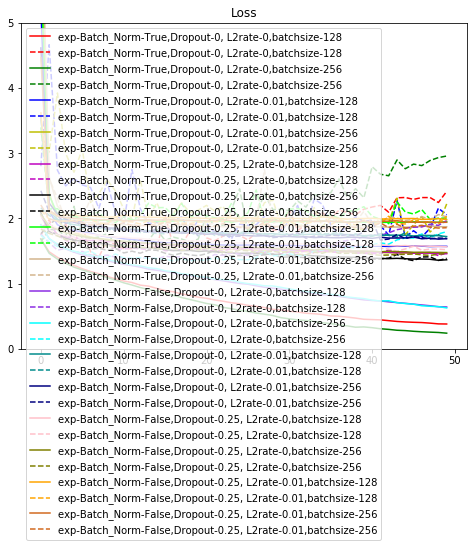

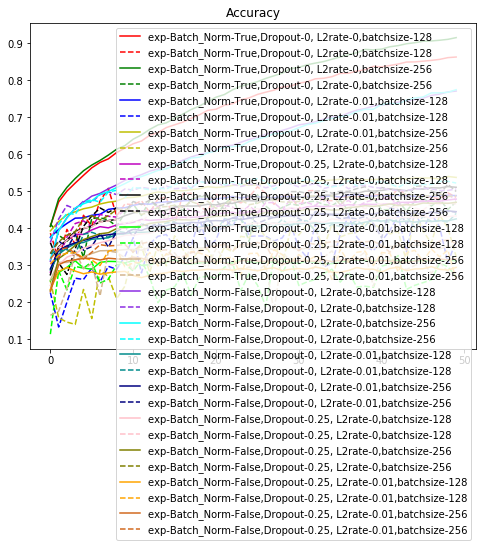

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k","lime","tan","blueviolet","aqua","darkcyan","navy","pink","olive","orange","chocolate"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()